# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

torch device: cuda


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

# Functions

# Data

In [3]:
data_dir_list = {
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001",
}


In [4]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"

# Graphing

## Mean Gaussian contact probability vs bead index

In [87]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=5):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Contact Probability')
    _ = axarr.set_ylim(1e-9, 2)
    _ = axarr.set_title(f'$k_o = 30$ sec$^{{-1}}$')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




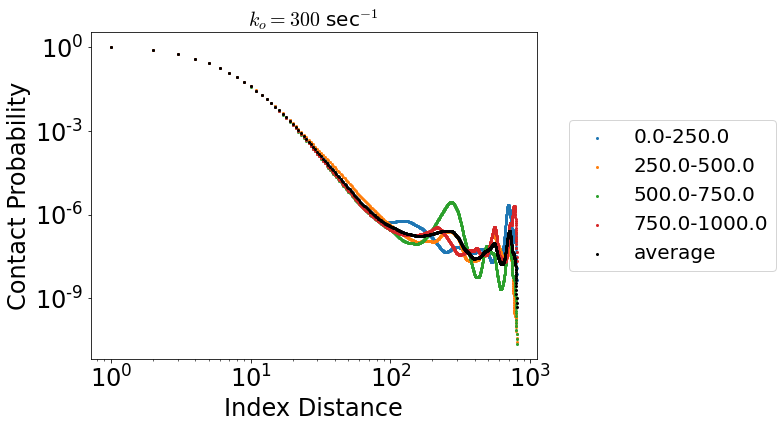

In [84]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=5):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    _ = axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Contact Probability')
    _ = axarr.set_title(f'$k_o = 300$ sec$^{{-1}}$')
    _ = axarr.set_ylim(1e-9, 2)
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Contact Probability')

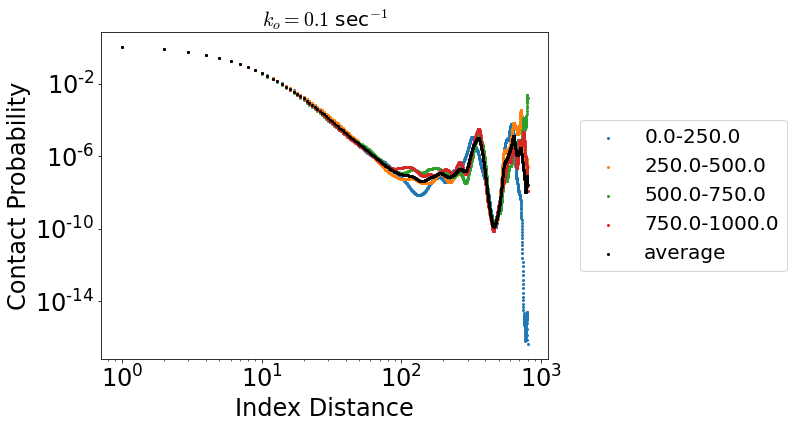

In [82]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=5):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    axarr.scatter(np.arange(avg_dist_v.size)+1, np.exp(-.5*np.power(avg_dist_v/.03,2)), c='k', label=f'average')

    axarr.set_yscale('log')
    axarr.set_xscale('log')
    axarr.set_xlabel('Index Distance')
    axarr.set_ylabel('Contact Probability')
    _ = axarr.set_title(f'$k_o = 0.1$ sec$^{{-1}}$')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




## Mean distance between beads vs bead index

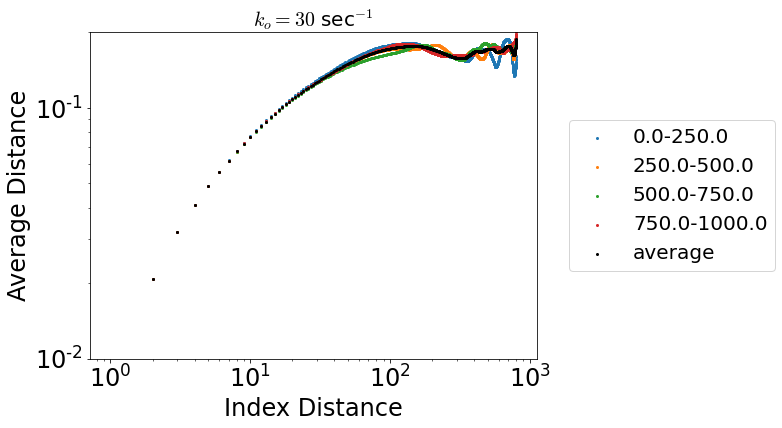

In [7]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=50):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    _ = axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Average Distance')
    _ = axarr.set_ylim(1e-2, .2)
    _ = axarr.set_title(f'$k_o = 30$ sec$^{{-1}}$')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

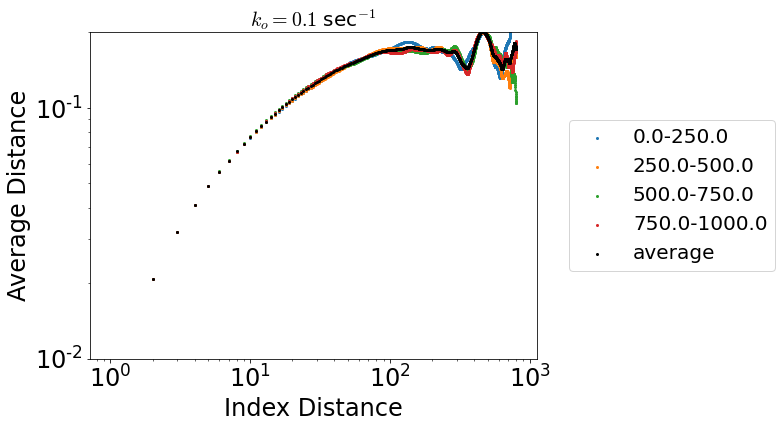

In [9]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=50):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    _ = axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Average Distance')
    _ = axarr.set_ylim(1e-2, .2)
    _ = axarr.set_title(f'$k_o = 0.1$ sec$^{{-1}}$')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

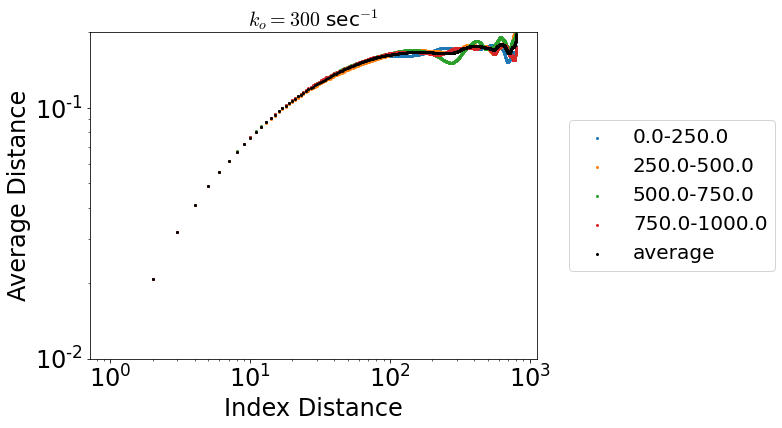

In [10]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    dt = time_arr[2] - time_arr[1]
    rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
    pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
    sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    spring_length = pparams['proteins'][0]['freeLength']
    # prot_dat = h5_data['raw_data/proteins'][:, :, 500]
    # print(rparams)

    fig, axarr = plt.subplots(1,1, figsize=(8, 6))
    n_steps = com_arr.shape[2]
    n_divs = 4
    div_len = n_steps // n_divs
    for j in range(n_divs):
        dist_v_arr = [] 
        for i in np.arange(j*div_len, (j+1)*div_len, step=50):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

        axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, label=f'{float((j*div_len))*dt}-{float(((j+1)*div_len))*dt}')
        # axarr.set_ylim(1e-3, .5)

    dist_v_arr = [] 
    for i in np.arange(n_steps, step=5*n_divs):
        dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
        dist_v_arr += [dist_v_gd.to('cpu').numpy()]
    avg_dist_v = np.mean(np.array(dist_v_arr), axis=0)

    _ = axarr.scatter(np.arange(avg_dist_v.size)+1, avg_dist_v, c='k', label=f'average')

    _ = axarr.set_yscale('log')
    _ = axarr.set_xscale('log')
    _ = axarr.set_xlabel('Index Distance')
    _ = axarr.set_ylabel('Average Distance')
    _ = axarr.set_ylim(1e-2, .2)
    _ = axarr.set_title(f'$k_o = 300$ sec$^{{-1}}$')
    _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

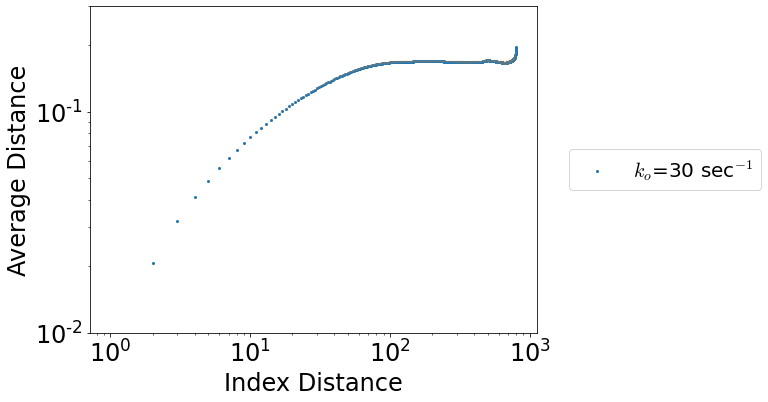

In [45]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
avg_dist_v = []
for dp in param_dir.glob("s*/analysis/raw*.h5"):
    with h5py.File(dp, 'r') as h5_data:
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        spring_length = pparams['proteins'][0]['freeLength']

        n_steps = com_arr.shape[2]
        dist_v_arr = [] 
        for i in np.arange(n_steps, step=100):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v += [np.mean(np.array(dist_v_arr), axis=0)]
avg_dist_std = np.array(avg_dist_v).std(axis=0)
avg_dist_mean = np.array(avg_dist_v).mean(axis=0)
bead_ind_arr = np.arange(avg_dist_mean.size)+1
ci_bound = .95

_ = axarr.scatter(bead_ind_arr, avg_dist_mean, label=f'$k_{{o}}$={30} sec$^{{-1}}$')
ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
_ = axarr.fill_between(bead_ind_arr, 
                    avg_dist_mean - ci, avg_dist_mean + ci, 
                    alpha=.25)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-2, .3)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Distance')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




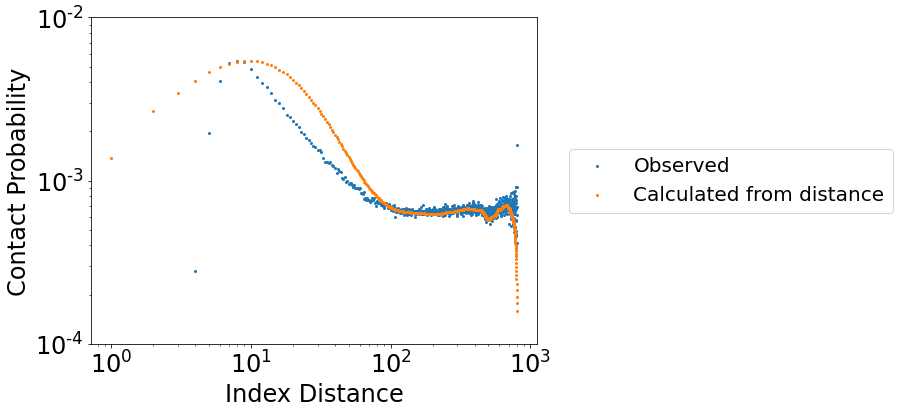

In [60]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"

fig, axarr = plt.subplots(1,1, figsize=(8, 6))
avg_dist_v = []
for dp in param_dir.glob("s*/analysis/raw*.h5"):
    with h5py.File(dp, 'r') as h5_data:
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        kbT = rparams['KBT']
        spring_length = pparams['proteins'][0]['freeLength']
        spring_const = pparams['proteins'][0]['kappa']

        n_steps = com_arr.shape[2]
        dist_v_arr = [] 
        for i in np.arange(n_steps, step=100):
            dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
            dist_v_arr += [dist_v_gd.to('cpu').numpy()]
        avg_dist_v += [np.mean(np.array(dist_v_arr), axis=0)]
avg_dist_std = np.array(avg_dist_v).std(axis=0)
avg_dist_mean = np.array(avg_dist_v).mean(axis=0)
bead_ind_arr = np.arange(avg_dist_mean.size)+1
ci_bound = .95

axarr.scatter(bead_ind_arr, combined_connect_prob, label=f'Observed')
_ = axarr.scatter(bead_ind_arr, np.max(combined_connect_prob)*np.exp(-np.power(avg_dist_mean - spring_length - .02, 2)/kbT) , label=f'Calculated from distance')

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(.0001, .01)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Contact Probability')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




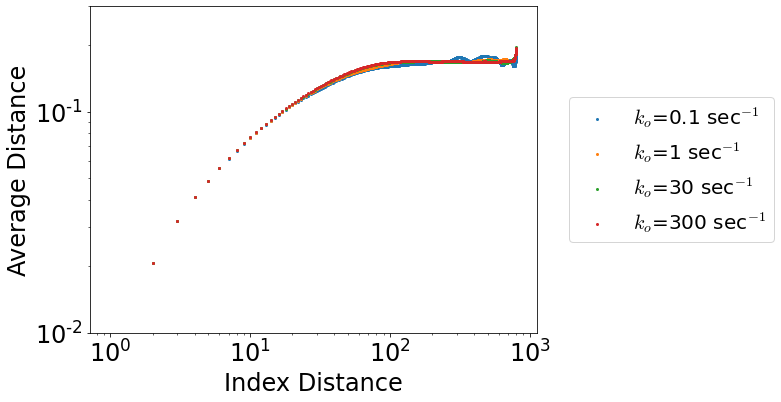

In [ ]:
param_dirs = [cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [0.1, 1, 30, 300]):
    avg_dist_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']

            n_steps = com_arr.shape[2]
            dist_v_arr = [] 
            for i in np.arange(n_steps, step=100):
                dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
                dist_v_arr += [dist_v_gd.to('cpu').numpy()]
            avg_dist_v += [np.mean(np.array(dist_v_arr), axis=0)]
    avg_dist_std = np.array(avg_dist_v).std(axis=0)
    avg_dist_mean = np.array(avg_dist_v).mean(axis=0)
    bead_ind_arr = np.arange(avg_dist_mean.size)+1
    ci_bound = .95

    _ = axarr.scatter(bead_ind_arr, avg_dist_mean, label=f'$k_{{o}}$={val} sec$^{{-1}}$')
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(bead_ind_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-2, .3)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Distance')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




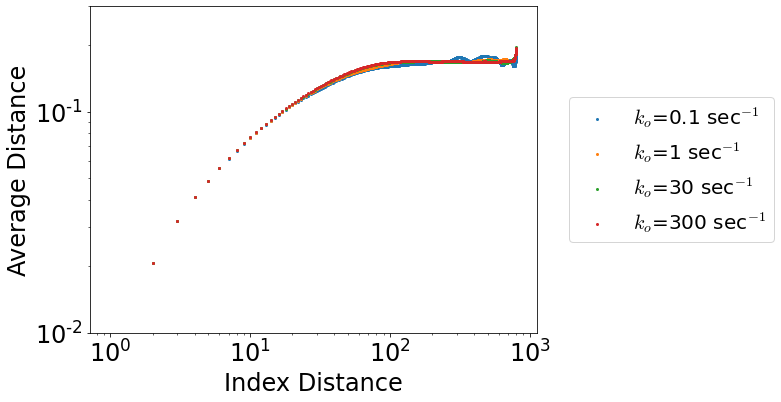

In [ ]:
param_dirs = [cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
for param_dir, val in zip(param_dirs, [0.1, 1, 30, 300]):
    avg_dist_v = []
    for dp in param_dir.glob("s*/analysis/raw*.h5"):
        with h5py.File(dp, 'r') as h5_data:
            time_arr = h5_data['time'][...]
            dt = time_arr[2] - time_arr[1]
            rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
            pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
            sy_dat = h5_data['raw_data']['sylinders'][:, :, 1:None]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            spring_length = pparams['proteins'][0]['freeLength']

            n_steps = com_arr.shape[2]
            dist_v_arr = [] 
            for i in np.arange(n_steps, step=100):
                dist_v_gd = cps.dist_vs_idx_dist(com_arr[:,:, i])
                dist_v_arr += [dist_v_gd.to('cpu').numpy()]
            avg_dist_v += [np.mean(np.array(dist_v_arr), axis=0)]
    avg_dist_std = np.array(avg_dist_v).std(axis=0)
    avg_dist_mean = np.array(avg_dist_v).mean(axis=0)
    bead_ind_arr = np.arange(avg_dist_mean.size)+1
    ci_bound = .95

    _ = axarr.scatter(bead_ind_arr, avg_dist_mean, label=f'$k_{{o}}$={val} sec$^{{-1}}$')
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(bead_ind_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

_ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(1e-2, .3)
_ = axarr.set_xlabel('Index Distance')
_ = axarr.set_ylabel('Average Distance')
_ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




## Mean connection vs bead index

Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Average Connection')

(0.0001, 0.01)

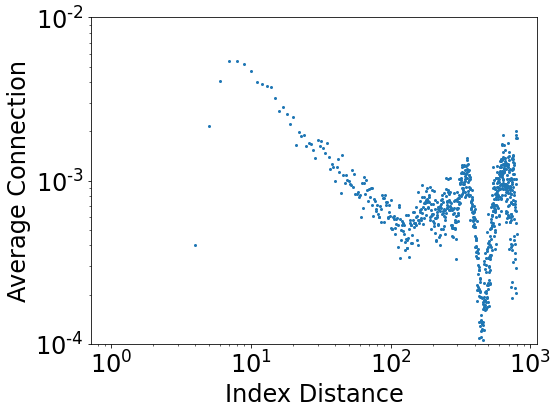

In [8]:
aram_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"
data_path = next((param_dir / "s1/analysis").glob("connect_analysis.h5"))

with h5py.File(data_path, 'r') as h5_data:
    avg_connect_mat = torch.from_numpy(h5_data['avg_connect_mat'][...]).to(device)
    time_arr = h5_data['time'][...]
    bead_num = avg_connect_mat.shape[0]
    avg_connect_prob = torch.zeros(bead_num).to(device)
    for i in range(1, bead_num):
        diag = torch.diagonal(avg_connect_mat, i)
        avg_connect_prob[i] = .5*diag.mean()
        diag = torch.diagonal(avg_connect_mat, -i)
        avg_connect_prob[i] += .5*diag.mean()

fig, axarr = plt.subplots(1,1, figsize=(8, 6)) 
axarr.scatter(np.arange(bead_num)+1, avg_connect_prob.cpu()/time_arr.size, label=f'average')
axarr.set_yscale('log')
axarr.set_xscale('log')
axarr.set_xlabel('Index Distance')
axarr.set_ylabel('Average Connection')
axarr.set_ylim(.0001, .01)



/mnt/home/alamson/projects/analysis/aLENS_analysis/alens_analysis/chromatin/chrom_poly_stats.py:302: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975312/work/aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return tmp.to_sparse_csr()


Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Connection Probability')

(0.0001, 0.01)

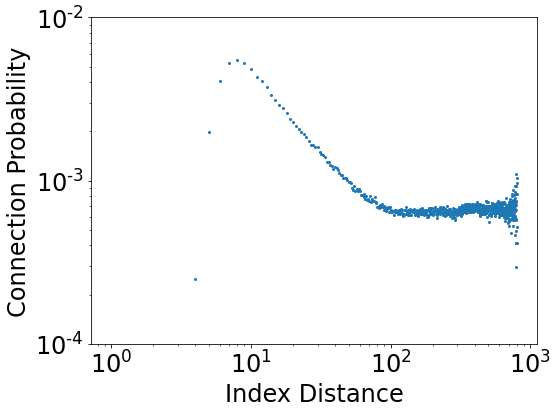

In [9]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300"
# data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))


combined_connect_prob = []
for dp in param_dir.glob("s*/analysis/raw*.h5"):
    with h5py.File(dp, 'r') as h5_data:
        time_arr = h5_data['time'][...]
        n = 0
        syl_dat = h5_data['raw_data/sylinders'][:,:,0]
        bead_num = syl_dat.shape[0]
        avg_connect_prob = torch.zeros(bead_num).to(device)
        for t_ind in range(0, time_arr.size, 100):
            prot_dat = h5_data['raw_data/proteins'][:,:,t_ind]
            connect_mat = cps.get_connect_torch_smat(prot_dat, bead_num, device=device).to_dense()
            connect_prob = torch.zeros(bead_num).to(device)
            for i in range(1, bead_num):
                diag = torch.diagonal(connect_mat, i)
                connect_prob[i] = .5*diag.mean()
                diag = torch.diagonal(connect_mat, -i)
                connect_prob[i] += .5*diag.mean()
            n+=1
            avg_connect_prob += connect_prob
        avg_connect_prob /= float(n)
    combined_connect_prob.append(avg_connect_prob.to('cpu').numpy())
combined_connect_prob = np.array(combined_connect_prob).mean(axis=0)


fig, axarr = plt.subplots(1,1, figsize=(8, 6)) 
axarr.scatter(np.arange(bead_num)+1, combined_connect_prob, label=f'average')
axarr.set_yscale('log')
axarr.set_xscale('log')
axarr.set_xlabel('Index Distance')
axarr.set_ylabel('Connection Probability')
axarr.set_ylim(.0001, .01)



/mnt/home/alamson/projects/analysis/aLENS_analysis/alens_analysis/chromatin/chrom_poly_stats.py:302: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975312/work/aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return tmp.to_sparse_csr()


Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Connection Probability')

(0.0001, 0.01)

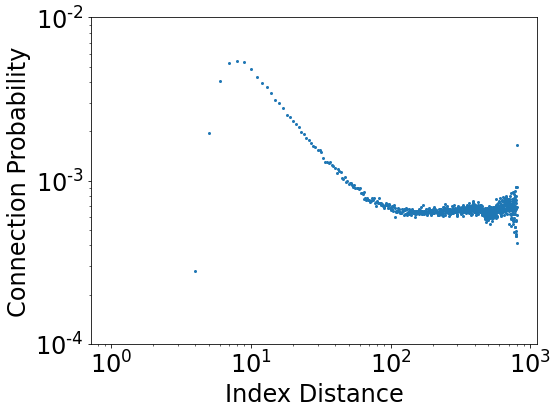

In [11]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"
# data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))


combined_connect_prob = []
for dp in param_dir.glob("s*/analysis/raw*.h5"):
    with h5py.File(dp, 'r') as h5_data:
        time_arr = h5_data['time'][...]
        n = 0
        syl_dat = h5_data['raw_data/sylinders'][:,:,0]
        bead_num = syl_dat.shape[0]
        avg_connect_prob = torch.zeros(bead_num).to(device)
        for t_ind in range(0, time_arr.size, 100):
            prot_dat = h5_data['raw_data/proteins'][:,:,t_ind]
            connect_mat = cps.get_connect_torch_smat(prot_dat, bead_num, device=device).to_dense()
            connect_prob = torch.zeros(bead_num).to(device)
            for i in range(1, bead_num):
                diag = torch.diagonal(connect_mat, i)
                connect_prob[i] = .5*diag.mean()
                diag = torch.diagonal(connect_mat, -i)
                connect_prob[i] += .5*diag.mean()
            n+=1
            avg_connect_prob += connect_prob
        avg_connect_prob /= float(n)
    combined_connect_prob.append(avg_connect_prob.to('cpu').numpy())
combined_connect_prob = np.array(combined_connect_prob).mean(axis=0)


fig, axarr = plt.subplots(1,1, figsize=(8, 6)) 
axarr.scatter(np.arange(bead_num)+1, combined_connect_prob, label=f'average')
axarr.set_yscale('log')
axarr.set_xscale('log')
axarr.set_xlabel('Index Distance')
axarr.set_ylabel('Connection Probability')
axarr.set_ylim(.0001, .01)



[-0.98948778  0.04579563]


Text(20, 0.004, '$s^{-0.99}$')

Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Connection Probability')

(0.0001, 0.01)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


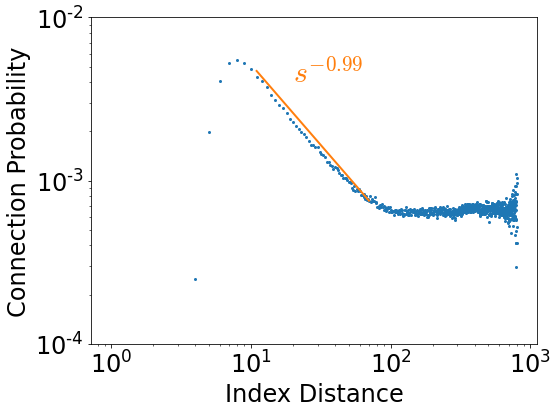

In [25]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6)) 
bead_ind_arr = np.arange(bead_num)+1
axarr.scatter(bead_ind_arr, combined_connect_prob, label=f'average')
# np.log(2*combined_connect_prob[10:80])
popt, pcov = curve_fit(lambda x, a, b: b*np.power(x,a), bead_ind_arr[10:70], combined_connect_prob[10:70], p0=(-2, 1))
print(popt)
axarr.plot(bead_ind_arr[10:70], 1.1*popt[1]*np.power(bead_ind_arr[10:70], popt[0]), label=f'average', c = 'tab:orange')
axarr.text(20, 0.004, f'$s^{{{popt[0]:.2f}}}$', fontsize=30, c = 'tab:orange')
axarr.set_yscale('log')
axarr.set_xscale('log')
axarr.set_xlabel('Index Distance')
axarr.set_ylabel('Connection Probability')
axarr.set_ylim(.0001, .01)

Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Connection Probability')

(0.0001, 0.01)

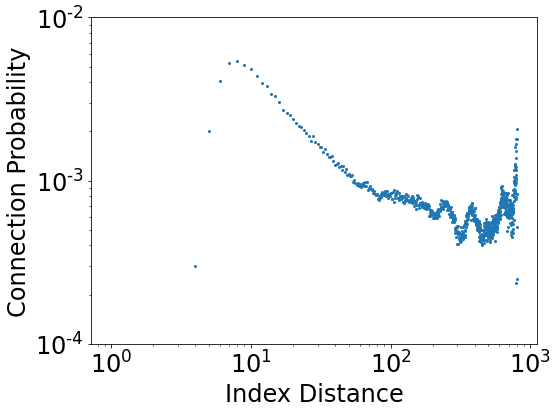

In [ ]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1"
# data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))


combined_connect_prob = []
for dp in param_dir.glob("s*/analysis/raw*.h5"):
    with h5py.File(dp, 'r') as h5_data:
        time_arr = h5_data['time'][...]
        n = 0
        syl_dat = h5_data['raw_data/sylinders'][:,:,0]
        bead_num = syl_dat.shape[0]
        avg_connect_prob = torch.zeros(bead_num).to(device)
        for t_ind in range(0, time_arr.size, 100):
            prot_dat = h5_data['raw_data/proteins'][:,:,t_ind]
            connect_mat = cps.get_connect_torch_smat(prot_dat, bead_num, device=device).to_dense()
            connect_prob = torch.zeros(bead_num).to(device)
            for i in range(1, bead_num):
                diag = torch.diagonal(connect_mat, i)
                connect_prob[i] = .5*diag.mean()
                diag = torch.diagonal(connect_mat, -i)
                connect_prob[i] += .5*diag.mean()
            n+=1
            avg_connect_prob += connect_prob
        avg_connect_prob /= float(n)
    combined_connect_prob.append(avg_connect_prob.to('cpu').numpy())
combined_connect_prob = np.array(combined_connect_prob).mean(axis=0)


fig, axarr = plt.subplots(1,1, figsize=(8, 6)) 
axarr.scatter(np.arange(bead_num)+1, combined_connect_prob, label=f'average')
axarr.set_yscale('log')
axarr.set_xscale('log')
axarr.set_xlabel('Index Distance')
axarr.set_ylabel('Connection Probability')
axarr.set_ylim(.0001, .01)



Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Connection Probability')

(0.0001, 0.01)

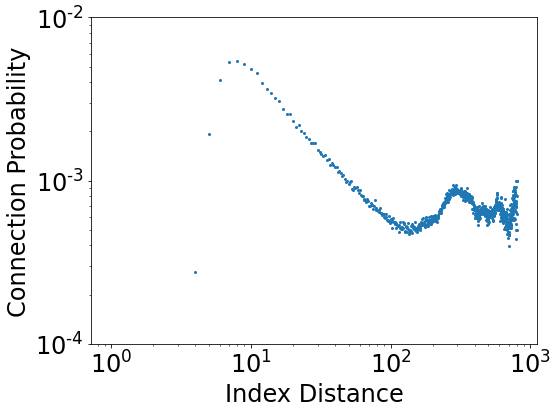

In [14]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    n = 0
    syl_dat = h5_data['raw_data/sylinders'][:,:,0]
    bead_num = syl_dat.shape[0]
    avg_connect_prob = torch.zeros(bead_num).to(device)
    for t_ind in range(0, time_arr.size, 10):
        prot_dat = h5_data['raw_data/proteins'][:,:,t_ind]
        connect_mat = cps.get_connect_torch_smat(prot_dat, bead_num, device=device).to_dense()
        connect_prob = torch.zeros(bead_num).to(device)
        for i in range(1, bead_num):
            diag = torch.diagonal(connect_mat, i)
            connect_prob[i] = .5*diag.mean()
            diag = torch.diagonal(connect_mat, -i)
            connect_prob[i] += .5*diag.mean()
        n+=1
        avg_connect_prob += connect_prob
    avg_connect_prob /= float(n)



fig, axarr = plt.subplots(1,1, figsize=(8, 6)) 
axarr.scatter(np.arange(bead_num)+1, avg_connect_prob.cpu(), label=f'average')
axarr.set_yscale('log')
axarr.set_xscale('log')
axarr.set_xlabel('Index Distance')
axarr.set_ylabel('Connection Probability')
axarr.set_ylim(.0001, .01)



Text(0.5, 0, 'Index Distance')

Text(0, 0.5, 'Connection')

(0.0001, 0.01)

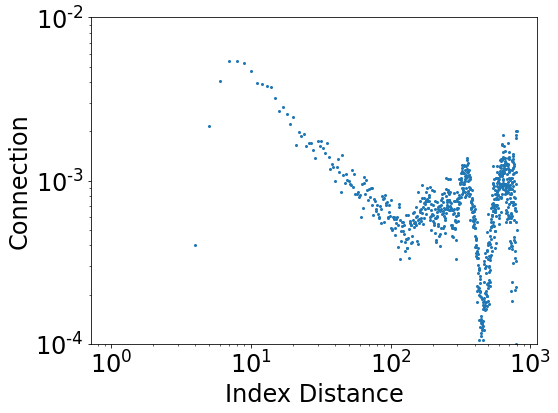

In [15]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    n = 0
    syl_dat = h5_data['raw_data/sylinders'][:,:,0]
    bead_num = syl_dat.shape[0]
    avg_connect_prob = torch.zeros(bead_num).to(device)
    for t_ind in range(0, time_arr.size, 10):
        prot_dat = h5_data['raw_data/proteins'][:,:,t_ind]
        connect_mat = cps.get_connect_torch_smat(prot_dat, bead_num, device=device).to_dense()
        connect_prob = torch.zeros(bead_num).to(device)
        for i in range(1, bead_num):
            diag = torch.diagonal(connect_mat, i)
            connect_prob[i] = .5*diag.mean()
            diag = torch.diagonal(connect_mat, -i)
            connect_prob[i] += .5*diag.mean()
        n+=1
        avg_connect_prob += connect_prob
    avg_connect_prob /= float(n)



fig, axarr = plt.subplots(1,1, figsize=(8, 6)) 
axarr.scatter(np.arange(bead_num)+1, avg_connect_prob.cpu(), label=f'average')
axarr.set_yscale('log')
axarr.set_xscale('log')
axarr.set_xlabel('Index Distance')
axarr.set_ylabel('Connection')
axarr.set_ylim(.0001, .01)



# Number of crosslinkers

534.1842631473705


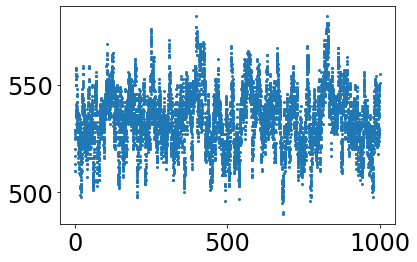

In [44]:
param_dir = cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1"
data_path = next((param_dir / "s1/analysis").glob("raw*.h5"))

with h5py.File(data_path, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    xlinking_ind = h5_data['raw_data/proteins'][:,-1,:] >= 0
    xlinking_ind = h5_data['raw_data/proteins'][xlinking_ind,-1,:]
    xlinking_num = np.sum(xlinking_ind, axis=0)
    plt.scatter(time_arr, xlinking_num)
    print(xlinking_num.mean())




{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 33.1], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1.0, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.055, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0, 0.1], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}]}
{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 33.1], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1.0, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.055, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0, 0.3], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}]}
{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 33.1], 'PtoAPratio': 1.0, '

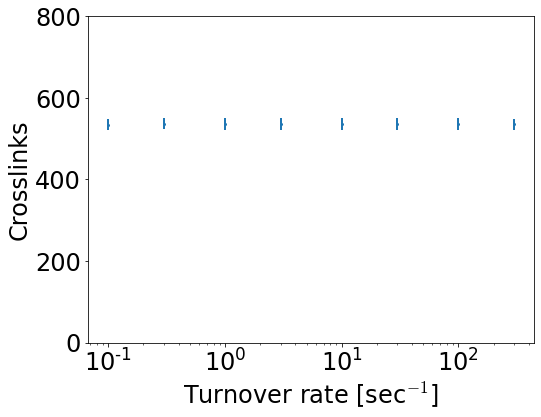

In [80]:
param_dirs = [
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.1",
    cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod0.3",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod1",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod3",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod10",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod30",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod100",
              cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations/kod300",
]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
bound_avg = []
bound_std = []
ko_arr = []
for param_dir in param_dirs:
    with h5py.File(next(param_dir.glob('s1/analysis/raw*.h5')), 'r') as h5_data:
        prot_dat = h5_data['raw_data/proteins'][...]
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        print(pparams)
        ko_arr += [pparams['proteins'][0]['ko_d'][1]] 
        n_bound = [np.sum(h5_data['raw_data/proteins'][:,-1,:] >= 0, axis=0)]
        bound_avg += [np.mean(n_bound)]
        bound_std += [np.std(n_bound)]
            

_ = axarr.errorbar(ko_arr, bound_avg, yerr=bound_std, marker='o', linestyle='none')

    # ci_bound = .95
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(ko_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

# _ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_ylim(0, 800)
_ = axarr.set_xlabel('Turnover rate [sec$^{-1}$]')
_ = axarr.set_ylabel('Crosslinks')
# _ = axarr.set_xlabel('Index Distance')
# _ = axarr.set_ylabel('Average Distance')
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 30.0], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.01, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0.0, 3.0], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}]}
{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 30.0], 'PtoAPratio': 1.0, 'diffBoundD': [0.0, 0.0], 'diffBoundS': [0.0, 0.0], 'diffUnbound': 0.01, 'eps': 1, 'fixedEnd0': True, 'fixedLocationPerMT': [0.0], 'freeLength': 0.02, 'freeNumber': 0, 'fstall': 5.0, 'kappa': 50.0, 'ko_d': [0.0, 3.0], 'ko_s': [0.0, 0.0], 'lambda': 0.0, 'rc': 0.039, 'tag': 0, 'useBindVol': False, 'vdrag': [False, False], 'vmax': [0.0, 0.0], 'walkOff': False}]}
{'KBT': 0.00411, 'proteins': [{'Ka': [3.22, 3.22], 'Ke': [0.662, 30.0], 'PtoAPratio': 1.0, 'di

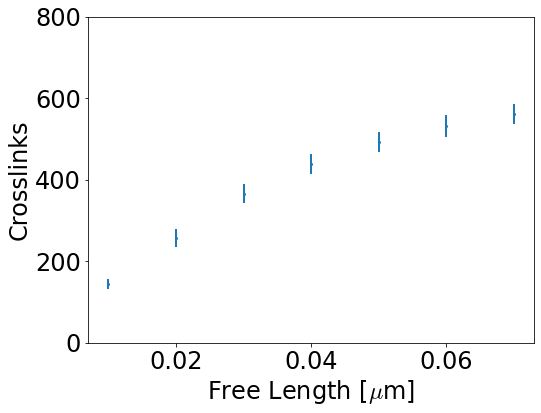

In [75]:
param_dirs = [
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.01',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.02',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.03',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.04',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.05',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.06',
    cond_path / '23-01-23_aLchr1_scan7.12_line800_Ke30_kod3_Ls.1-.7nm_equil/simulations/Ls0.07',
    ]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
bound_avg = []
bound_std = []
ko_arr = []
for param_dir in param_dirs:
    with h5py.File(next(param_dir.glob('s1/analysis/raw*.h5')), 'r') as h5_data:
        prot_dat = h5_data['raw_data/proteins'][...]
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        print(pparams)
        ko_arr += [pparams['proteins'][0]['freeLength']]
        n_bound = [np.sum(h5_data['raw_data/proteins'][:,-1,:] >= 0, axis=0)]
        bound_avg += [np.mean(n_bound)]
        bound_std += [np.std(n_bound)]
            

_ = axarr.errorbar(ko_arr, bound_avg, yerr=bound_std, marker='o', linestyle='none')

    # ci_bound = .95
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(ko_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

# _ = axarr.set_yscale('log')
# _ = axarr.set_xscale('log')
_ = axarr.set_ylim(0, 800)
_ = axarr.set_xlabel('Free Length [$\mu$m]')
_ = axarr.set_ylabel('Crosslinks')
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    




[array([ 0,  0,  7, ...,  6, 10, 11])]
[array([  0,   0,  23, ...,  93,  92, 101])]
[array([  0,   0,  60, ..., 252, 257, 252])]
[array([  0,   0, 123, ..., 431, 446, 434])]
[array([  0,   0, 187, ..., 539, 539, 493])]
[array([  0,   0, 262, ..., 614, 625, 602])]
[array([  0,   0, 429, ..., 693, 702, 687])]
[array([  0,   0, 569, ..., 729, 750, 734])]
[9.273736812881733, 95.84314269850083, 249.90560799555803, 422.4575235980011, 513.7887284841754, 607.1757357023876, 693.3192670738479, 743.7731815657968]


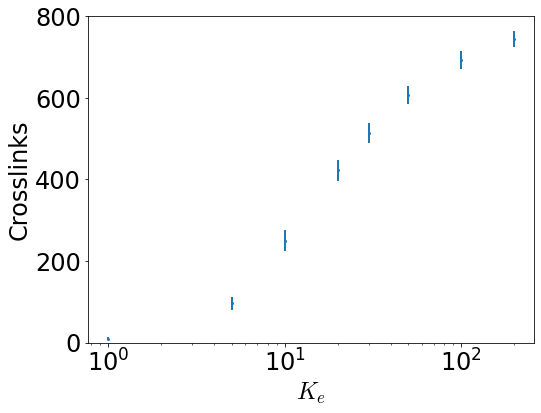

In [76]:
param_dirs = [
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke1',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke5',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke10',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke20',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke30',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke50',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke100',
    cond_path / '23-01-09_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200_equil/simulations/Ke200',
    ]



fig, axarr = plt.subplots(1,1, figsize=(8, 6))
bound_avg = []
bound_std = []
ko_arr = []
for param_dir in param_dirs:
    with h5py.File(next(param_dir.glob('s1/analysis/raw*.h5')), 'r') as h5_data:
        prot_dat = h5_data['raw_data/proteins'][...]
        time_arr = h5_data['time'][...]
        dt = time_arr[2] - time_arr[1]
        rparams = yaml.safe_load(h5_data.attrs['RunConfig'])
        pparams = yaml.safe_load(h5_data.attrs['ProteinConfig'])
        # print(pparams)
        ko_arr += [pparams['proteins'][0]['Ke'][1]]
        n_bound = [np.sum(h5_data['raw_data/proteins'][:,-1,:] >= 0, axis=0)]
        print(n_bound)
        bound_avg += [np.mean(n_bound)]
        bound_std += [np.std(n_bound)]
            

print(bound_avg)
_ = axarr.errorbar(ko_arr, bound_avg, yerr=bound_std, marker='o', linestyle='none')

    # ci_bound = .95
    # ci = (avg_dist_std/np.sqrt(12.) * (np.sqrt(2)*erfinv(ci_bound)))
    # _ = axarr.fill_between(ko_arr, 
    #                     avg_dist_mean - ci, avg_dist_mean + ci, 
    #                     alpha=.25)

# _ = axarr.set_yscale('log')
_ = axarr.set_xscale('log')
_ = axarr.set_xlabel('$K_e$')
_ = axarr.set_ylabel('Crosslinks')
_ = axarr.set_ylim(0, 800)
# _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    


